<a href="https://colab.research.google.com/github/Arpit1118/Pytorch/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

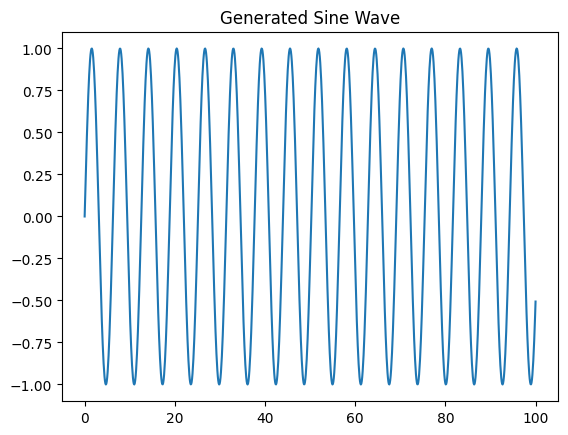

In [2]:
# Generate some sample data (sine wave)
t = np.linspace(0, 100, 1000)  # 1000 points from 0 to 100
data = np.sin(t)

# Visualize the sine wave
plt.plot(t, data)
plt.title('Generated Sine Wave')
plt.show()

# Rescale the data to [0, 1] for better training
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))


In [3]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)

    return np.array(sequences), np.array(labels)

# Create sequences of length 10
seq_length = 10
X, y = create_sequences(data_scaled, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

# Add an additional dimension for the LSTM input (batch_size, seq_length, input_size)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Shape will be (batch_size, seq_length, input_size)

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Only take the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        predictions = self.linear(lstm_out)
        return predictions


In [5]:
input_size = 1  # since we are using univariate data
hidden_layer_size = 64  # You can adjust this
output_size = 1  # We are predicting the next value

# Initialize the model
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
epochs = 100  # Number of training epochs
for epoch in range(epochs):
    model.train()

    # Forward pass
    optimizer.zero_grad()
    y_pred = model(X_train)

    # Compute the loss
    loss = loss_fn(y_pred, y_train)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Epoch 10/100, Loss: 0.17128939926624298
Epoch 20/100, Loss: 0.09606143832206726
Epoch 30/100, Loss: 0.07919783890247345
Epoch 40/100, Loss: 0.0601559542119503
Epoch 50/100, Loss: 0.040396738797426224
Epoch 60/100, Loss: 0.023135976865887642
Epoch 70/100, Loss: 0.013851553201675415
Epoch 80/100, Loss: 0.009454919956624508
Epoch 90/100, Loss: 0.007034484762698412
Epoch 100/100, Loss: 0.004970550537109375


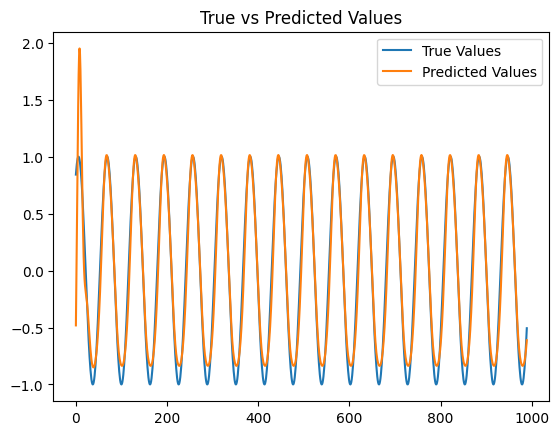

In [7]:
model.eval()

# Use the model to predict the next value in the sequence
with torch.no_grad():
    predictions = model(X_train)

# Convert the predictions back to the original scale
predicted_values = scaler.inverse_transform(predictions.numpy())

# Convert actual values back to the original scale
true_values = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))

# Visualize the predicted vs true values
plt.plot(true_values, label='True Values')
plt.plot(predicted_values, label='Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.show()
